In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir(globals()['_dh'][0])
os.chdir('..')

import numpy as np
import matplotlib.pyplot as plt
import pickle

import rfcutils
get_pow = lambda s: np.mean(np.abs(s)**2)
get_sinr = lambda s1, s2: 10*np.log10(get_pow(s1)/get_pow(s2))
get_mse = lambda s: np.mean(np.abs(s)**2)

---

## Separation Challenge

#### Reference Method 1: LMMSE Estimation (with empirical statistics)

Given a mixture of two components, $$y = s + b,$$ we can use the LMMSE estimator to estimate the $s$ component from the mixture $y$, i.e., 
$$\hat{s} = \bar{s} + W(y-\bar{s}-\bar{b}),$$
$$W = C_{sy}C_{yy}^{-1} = C_{ss}(C_{ss} + C_{bb})^{-1},$$
where $\bar{s}$, $\bar{b}$ are the means and $C_{ss}$, $C_{bb}$ are the covariances of $s$ and $b$ respectively.

(Here, we assume that $s$ and $b$ are statistically independent.) 

Note that we can, in turn, get an estimate of $b$ by taking $\hat{b}=y-\hat{s}$.

While we do not have the true statistics of $s$ and $b$ in this setup, note that we can estimate them from the respective examples in the training dataset, thereby obtaining the corresponding empirical estimates on the mean and covariance. 


The LMMSE estimation implemented here is performed in blocks of 4000 samples long. Further, alignment with respect to CommSignal2 is performed (by performing a cross-correlation with a "reference window" from one of the training data samples and time-shifting the signal accordingly) prior to the LMMSE estimation.

In [3]:
from example.sep_lmmse.lmmse_estimator import lmmse_separate as sep_lmmse_separate

align_soi = True
dataset_type = 'sep_val'
interference_sig_type = 'EMISignal1'
idx = 401

sig_mixture,meta = rfcutils.load_dataset_sample(idx, dataset_type, interference_sig_type)
sig1,meta1,sig2,meta2 = rfcutils.load_dataset_sample_components(idx, dataset_type, interference_sig_type)

sinr = get_sinr(sig1, sig2)
mse_ref = get_mse(sig_mixture-sig1)

sig1_mmse, sig2_mmse = sep_lmmse_separate(sig_mixture, soi_type='CommSignal2', interference_sig_type=interference_sig_type, align_soi=align_soi)

#401 -- SINR -3.000dB: SDR: 4.81395 dB, MSE: 0.33007
(Reference MSE without separation: 1.99526)


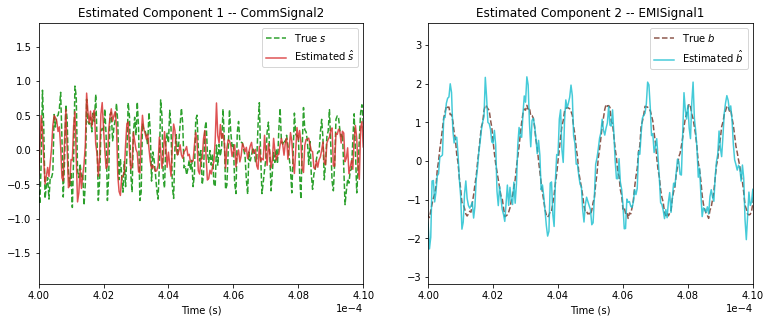

In [4]:
fs = 25e6
plt.figure(figsize=(12.8,4.8))
t_axis = np.arange(40960)/fs

xlim_window = [4.0e-4, 4.1e-4]

plt.subplot(121)
plt.plot(t_axis, sig1.real, '--', color='tab:green')
plt.plot(t_axis, sig1_mmse.real, color='tab:red', alpha=0.8)
plt.ticklabel_format(scilimits=[-2, 3])
plt.xlabel('Time (s)')
plt.xlim(xlim_window)
plt.legend(['True $s$', 'Estimated $\hat s$'])
plt.title('Estimated Component 1 -- CommSignal2')

plt.subplot(122)
plt.plot(t_axis, sig2.real, '--', color='tab:brown')
plt.plot(t_axis, sig2_mmse.real, color='tab:cyan', alpha=0.8)
plt.ticklabel_format(scilimits=[-2, 3])
plt.xlabel('Time (s)')
plt.xlim(xlim_window)
plt.legend(['True $b$', 'Estimated $\hat b$'])
plt.title(f'Estimated Component 2 -- {interference_sig_type}')



sinr = get_sinr(sig1, sig2)
mse_ref = get_mse(sig_mixture-sig1)
mse = get_mse(sig1_mmse-sig1)
sdr = get_sinr(sig1, sig1-sig1_mmse)

print(f"#{idx} -- SINR {sinr:.3f}dB: SDR: {sdr:.05f} dB, MSE: {mse:.05f}")
print(f"(Reference MSE without separation: {mse_ref:.05f})")
plt.show()

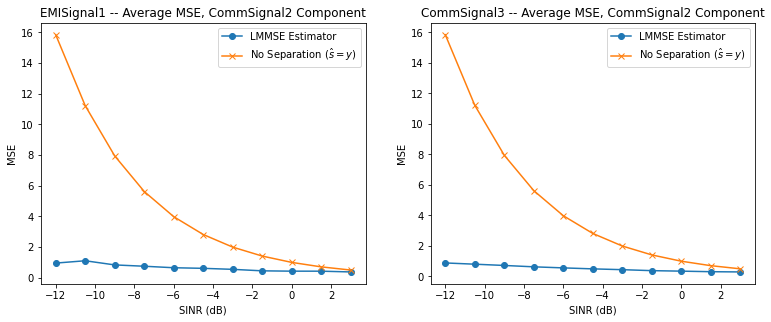

In [5]:
plt.figure(figsize=(12.8, 4.8)) 

val_or_test = 'val'
align_soi = True
align_soi_str = 'aligned' if align_soi else 'not_aligned'
all_ref_str = ['EMISignal1', 'CommSignal3']

for i in range(len(all_ref_str)):
    all_mse, all_default_mse, all_sdr, all_sinr = pickle.load(open(os.path.join('example','sep_lmmse','output',f'lmmse_{all_ref_str[i]}_{val_or_test}_sep_{align_soi_str}.pickle'), 'rb'))
    mean_mse_per_sinr = np.array(all_mse).reshape(-1,100).mean(axis=1)
    mean_default_mse_per_sinr = np.array(all_default_mse).reshape(-1,100).mean(axis=1)
    sinr_axis = np.array(all_sinr).reshape(-1,100).mean(axis=1)

    plt.subplot(1, 2, i+1)
    plt.plot(sinr_axis, mean_mse_per_sinr, 'o-')
    plt.plot(sinr_axis, mean_default_mse_per_sinr, 'x-')
    plt.title(f'{all_ref_str[i]} -- Average MSE, CommSignal2 Component')
    plt.xlabel('SINR (dB)')
    plt.ylabel('MSE')
    plt.legend(['LMMSE Estimator', 'No Separation ($\hat s = y$)'], loc="upper right")

---

## Demodulation Challenge

#### Reference 0: Matched Filtering (no interference mitigation)

Given the signal $s$, we can perform matched filtering to estimate the information bits. In the problem setup, we assume that the parameters of the modulation are known, and that the signal-of-interest has already been aligned and scaled accordingly. Hence, demodulation is simply the convolution with the (known) pulse-shaping function, and sampling at the symbol rate.

In the case of the mixture signal $y=s+b$, if we do not perform interference mitigation, we can still perform the classical matched filtering on the signal $y$ (thereby treating the interference as noise, ***which is often supoptimal***). As expected, as demonstrated in the plots, this would result in significant deterioration in demodulation performance, particularly when strong interference is present.

In [6]:
dataset_type = 'demod_val'
interference_sig_type = 'CommSignal2'
idx = 401

sig_mixture,meta = rfcutils.load_dataset_sample(idx, dataset_type, interference_sig_type)
sig1,meta1,sig2,meta2 = rfcutils.load_dataset_sample_components(idx, dataset_type, interference_sig_type)

sinr = get_sinr(sig1, sig2)
ber_ref = rfcutils.demod_check_ber(rfcutils.matched_filter_demod(sig_mixture), idx, dataset_type, interference_sig_type)

print(f"#{idx} -- SINR {sinr:.3f}dB: BER: {ber_ref:.05f}")

#401 -- SINR -3.000dB: BER: 0.05625


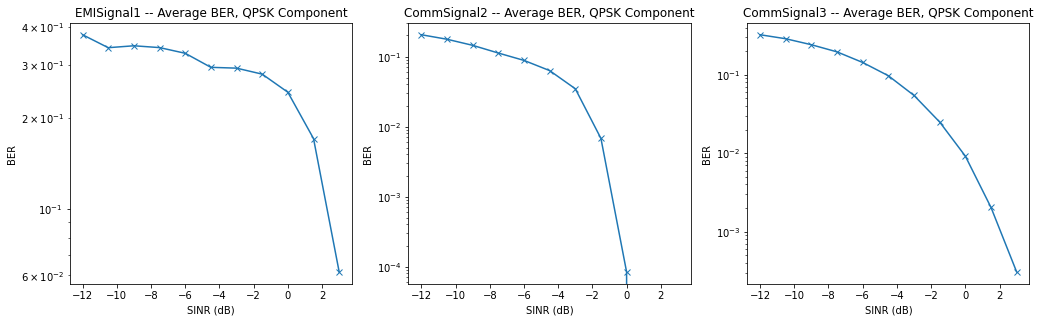

In [8]:
plt.figure(figsize=(17.2, 4.8)) 

val_or_test = 'val'
all_ref_str = ['EMISignal1', 'CommSignal2', 'CommSignal3']

for i in range(len(all_ref_str)):
    all_default_ber, all_sinr = pickle.load(open(os.path.join('example','demod_matched_filtering','output',f'matchedfiltering_{all_ref_str[i]}_{val_or_test}_demod.pickle'), 'rb'))
    mean_default_ber_per_sinr = np.array(all_default_ber).reshape(-1,100).mean(axis=1)
    sinr_axis = np.array(all_sinr).reshape(-1,100).mean(axis=1)

    plt.subplot(1, 3, i+1)
    plt.semilogy(sinr_axis, mean_default_ber_per_sinr, 'x-')
    plt.title(f'{all_ref_str[i]} -- Average BER, QPSK Component')
    plt.xlabel('SINR (dB)')
    plt.ylabel('BER')    
    

#### Reference Method 1: LMMSE Estimation (with empirical statistics) + Matched Filtering

Given a mixture of two components, $$y = s + b,$$ we can use the LMMSE estimator to estimate the $s$ component from the mixture $y$, i.e., 
$$\hat{s} = \bar{s} + W(y-\bar{s}-\bar{b}),$$
$$W = C_{sy}C_{yy}^{-1} = C_{ss}(C_{ss} + C_{bb})^{-1},$$
where $\bar{s}$, $\bar{b}$ are the means and $C_{ss}$, $C_{bb}$ are the covariances of $s$ and $b$ respectively.

(Here, we assume that $s$ and $b$ are statistically independent.) 

Note that we can, in turn, get an estimate of $b$ by taking $\hat{b}=y-\hat{s}$.

While we do not have the true statistics of $s$ and $b$ in this setup, note that we can estimate the first and second order statistics from the respective datasets, thereby obtaining the corresponding empirical estimates on the mean and covariance. 


The LMMSE estimation implemented here is performed in blocks of 4000 samples long.

Once an estimate on the QPSK waveform is obtained, we perform a standard matched filtering on $\hat{s}$ to demodulate the signal and estimate the information bits. 

In [9]:
from example.demod_lmmse.lmmse_estimator import lmmse_separate as demod_lmmse_separate

align_soi = True
dataset_type = 'demod_val'
interference_sig_type = 'CommSignal2'
idx = 401

sig_mixture,meta = rfcutils.load_dataset_sample(idx, dataset_type, interference_sig_type)
sig1,meta1,sig2,meta2 = rfcutils.load_dataset_sample_components(idx, dataset_type, interference_sig_type)

sinr = get_sinr(sig1, sig2)
mse_ref = get_mse(sig_mixture-sig1)

sig1_mmse, sig2_mmse = demod_lmmse_separate(sig_mixture, soi_type='QPSK', interference_sig_type=interference_sig_type)

#401 -- SINR -3.000dB: SDR: 6.94519 dB, BER: 0.05391
(Reference BER from standard matched filtering: 0.05625)


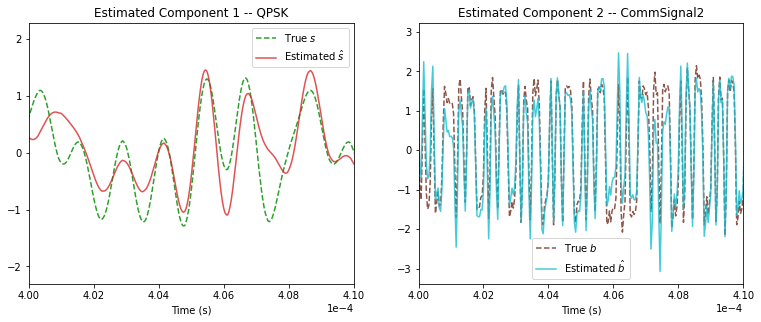

In [10]:
fs = 25e6
plt.figure(figsize=(12.8,4.8))
t_axis = np.arange(40960)/fs

xlim_window = [4.0e-4, 4.1e-4]

plt.subplot(121)
plt.plot(t_axis, sig1.real, '--', color='tab:green')
plt.plot(t_axis, sig1_mmse.real, color='tab:red', alpha=0.8)
plt.ticklabel_format(scilimits=[-2, 3])
plt.xlabel('Time (s)')
plt.xlim(xlim_window)
plt.legend(['True $s$', 'Estimated $\hat s$'])
plt.title('Estimated Component 1 -- QPSK')

plt.subplot(122)
plt.plot(t_axis, sig2.real, '--', color='tab:brown')
plt.plot(t_axis, sig2_mmse.real, color='tab:cyan', alpha=0.8)
plt.ticklabel_format(scilimits=[-2, 3])
plt.xlabel('Time (s)')
plt.xlim(xlim_window)
plt.legend(['True $b$', 'Estimated $\hat b$'])
plt.title(f'Estimated Component 2 -- {interference_sig_type}')



sinr = get_sinr(sig1, sig2)
ber_ref = rfcutils.demod_check_ber(rfcutils.matched_filter_demod(sig_mixture), idx, dataset_type, interference_sig_type)
bit_est = rfcutils.matched_filter_demod(sig1_mmse)
ber = rfcutils.demod_check_ber(bit_est, idx, dataset_type, interference_sig_type)
sdr = get_sinr(sig1, sig1-sig1_mmse)

print(f"#{idx} -- SINR {sinr:.3f}dB: SDR: {sdr:.05f} dB, BER: {ber:.05f}")
print(f"(Reference BER from standard matched filtering: {ber_ref:.05f})")
plt.show()

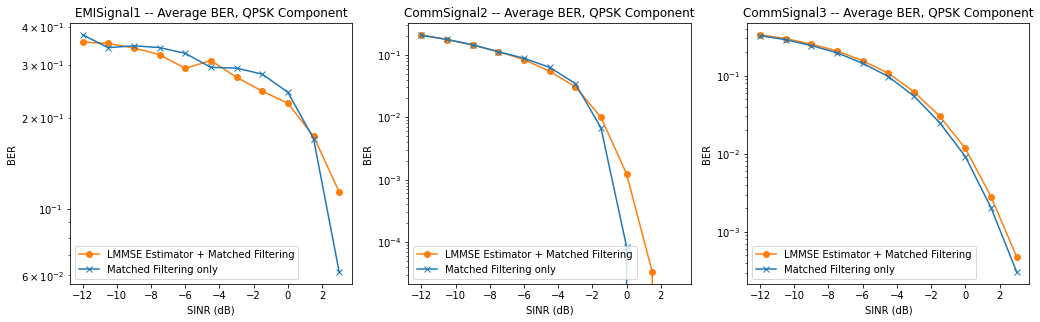

In [16]:
plt.figure(figsize=(17.2, 4.8)) 

val_or_test = 'val'
all_ref_str = ['EMISignal1', 'CommSignal2', 'CommSignal3']

for i in range(len(all_ref_str)):
    all_ber, all_default_ber, all_sdr, all_sinr = pickle.load(open(os.path.join('example','demod_lmmse','output',f'lmmse_{all_ref_str[i]}_{val_or_test}_demod.pickle'), 'rb'))
    mean_ber_per_sinr = np.array(all_ber).reshape(-1,100).mean(axis=1)
    mean_default_ber_per_sinr = np.array(all_default_ber).reshape(-1,100).mean(axis=1)
    sinr_axis = np.array(all_sinr).reshape(-1,100).mean(axis=1)

    plt.subplot(1, 3, i+1)
    plt.semilogy(sinr_axis, mean_ber_per_sinr, 'o-', color='tab:orange')
    plt.semilogy(sinr_axis, mean_default_ber_per_sinr, 'x-', color='tab:blue')
    plt.title(f'{all_ref_str[i]} -- Average BER, QPSK Component')
    plt.xlabel('SINR (dB)')
    plt.ylabel('BER')
    plt.legend(['LMMSE Estimator + Matched Filtering', 'Matched Filtering only'], loc="lower left")

<div class="alert alert-block alert-info">
<b>Special Case with CommSignal2</b>
<br><br>
    
<b>Note</b>: a slightly better performance can be obtained by trying to capture the temporal offset of the CommSignal2 (akin to "aligning" the CommSignal2 interference).

The covariance used for CommSignal2 in the earlier example aggregates across random shifts along the time axis. However, if we can estimate the offset in time, we can better exploit the temporal structure present in CommSignal2.

However, this particular adjustment is specific to the case of CommSignal2. We encourage participants to consider solutions that can be generalized across the different signal types, rather than handcrafted adjustments for particular signal types (as is done in this case).

</div>

In [12]:
from example.demod_lmmse.align_lmmse_estimator import align_lmmse_separate as demod_align_lmmse_separate

align_soi = True
dataset_type = 'demod_val'
interference_sig_type = 'CommSignal2'
idx = 401

sig_mixture,meta = rfcutils.load_dataset_sample(idx, dataset_type, interference_sig_type)
sig1,meta1,sig2,meta2 = rfcutils.load_dataset_sample_components(idx, dataset_type, interference_sig_type)

sinr = get_sinr(sig1, sig2)
mse_ref = get_mse(sig_mixture-sig1)

sig1_mmse, sig2_mmse = demod_align_lmmse_separate(sig_mixture, soi_type='QPSK', interference_sig_type=interference_sig_type)

#401 -- SINR -3.000dB: SDR: 14.85079 dB, BER: 0.00000
(Reference BER from standard matched filtering: 0.05625)


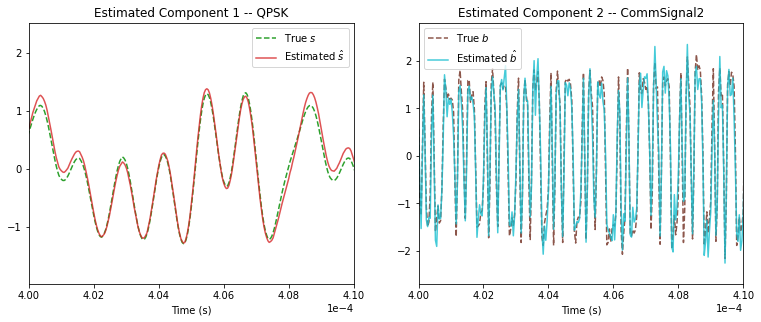

In [13]:
fs = 25e6
plt.figure(figsize=(12.8,4.8))
t_axis = np.arange(40960)/fs

xlim_window = [4.0e-4, 4.1e-4]

plt.subplot(121)
plt.plot(t_axis, sig1.real, '--', color='tab:green')
plt.plot(t_axis, sig1_mmse.real, color='tab:red', alpha=0.8)
plt.ticklabel_format(scilimits=[-2, 3])
plt.xlabel('Time (s)')
plt.xlim(xlim_window)
plt.legend(['True $s$', 'Estimated $\hat s$'])
plt.title('Estimated Component 1 -- QPSK')

plt.subplot(122)
plt.plot(t_axis, sig2.real, '--', color='tab:brown')
plt.plot(t_axis, sig2_mmse.real, color='tab:cyan', alpha=0.8)
plt.ticklabel_format(scilimits=[-2, 3])
plt.xlabel('Time (s)')
plt.xlim(xlim_window)
plt.legend(['True $b$', 'Estimated $\hat b$'])
plt.title(f'Estimated Component 2 -- {interference_sig_type}')



sinr = get_sinr(sig1, sig2)
ber_ref = rfcutils.demod_check_ber(rfcutils.matched_filter_demod(sig_mixture), idx, dataset_type, interference_sig_type)
bit_est = rfcutils.matched_filter_demod(sig1_mmse)
ber = rfcutils.demod_check_ber(bit_est, idx, dataset_type, interference_sig_type)
sdr = get_sinr(sig1, sig1-sig1_mmse)

print(f"#{idx} -- SINR {sinr:.3f}dB: SDR: {sdr:.05f} dB, BER: {ber:.05f}")
print(f"(Reference BER from standard matched filtering: {ber_ref:.05f})")
plt.show()

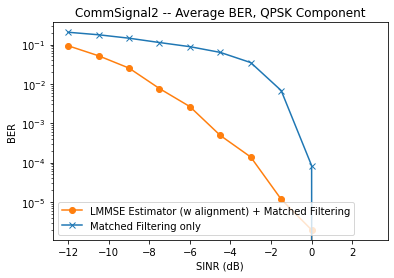

In [17]:
plt.figure() 

val_or_test = 'val'
all_ref_str = ['EMISignal1', 'CommSignal2', 'CommSignal3']

i = 1
all_ber, all_default_ber, all_sdr, all_sinr = pickle.load(open(os.path.join('example','demod_lmmse','output',f'lmmse_{all_ref_str[i]}_{val_or_test}_demod_aligned.pickle'), 'rb'))
mean_ber_per_sinr = np.array(all_ber).reshape(-1,100).mean(axis=1)
mean_default_ber_per_sinr = np.array(all_default_ber).reshape(-1,100).mean(axis=1)
sinr_axis = np.array(all_sinr).reshape(-1,100).mean(axis=1)

plt.semilogy(sinr_axis, mean_ber_per_sinr, 'o-', color='tab:orange')
plt.semilogy(sinr_axis, mean_default_ber_per_sinr, 'x-', color='tab:blue')
plt.title(f'{all_ref_str[i]} -- Average BER, QPSK Component')
plt.xlabel('SINR (dB)')
plt.ylabel('BER') 
plt.legend(['LMMSE Estimator (w alignment) + Matched Filtering', 'Matched Filtering only'], loc="lower left")

#### Reference Method 2: Supervised Learning Method to Estimate Bit Probabilities ("Bit Regression")

A machine learning approach to the demodulation task is to train a "demodulation function" in a supervised learning fashion. Specifically, we can create a labelled dataset where the inputs are examples of the mixture signals $y$ (for a particular interference class), and the outputs are bit probabilities (denoted as $p$; this corresponds to a final layer with a sigmoid activation function, with each output corresponding to probability that the bit in that position is 1). 

In this implementation, we trained a neural network that takes in blocks of 1024 samples long, and estimate the probabilities of the corresponding 128 bits. Finally, a "hard decision" on the information bit estimate is made by setting a threshold value of 0.5 (i.e., the corresponding bit is 1 if $p>0.5$, and 0 otherwise). 

<div class="alert alert-block alert-info">
    
<i><b>Note</b>: This solution involves training a neural network model for each combination of signal-of-interest and interference mixture. 
In other words, if a new type of signal-of-interest is considered, or a new class of signal is introduced as the interference, we will need to retrain models to account for all possible combinations involving these new signal types. 
    
Are you able to develop solutions that are scalable when new signal types are introduced, and does not require intensive re-training or rely on huge training set to account for all possible combinations of the signal types?</i>
    
</div>

In [14]:
from example.demod_bitregression.bitregression_model import demod_bits, get_model

dataset_type = 'demod_val'
interference_sig_type = 'CommSignal2'
idx = 401

sig_mixture,meta = rfcutils.load_dataset_sample(idx, dataset_type, interference_sig_type)
sig1,meta1,sig2,meta2 = rfcutils.load_dataset_sample_components(idx, dataset_type, interference_sig_type)

sinr = get_sinr(sig1, sig2)
ber_ref = rfcutils.demod_check_ber(rfcutils.matched_filter_demod(sig_mixture), idx, dataset_type, interference_sig_type)
bit_est = demod_bits(sig_mixture, interference_sig_type=interference_sig_type)
ber = rfcutils.demod_check_ber(bit_est, idx, dataset_type, interference_sig_type)

print(f"#{idx} -- SINR {sinr:.3f}dB: BER: {ber:.05f}")
print(f"(Reference BER from standard matched filtering: {ber_ref:.05f})")

#401 -- SINR -3.000dB: BER: 0.00000
(Reference BER from standard matched filtering: 0.05625)


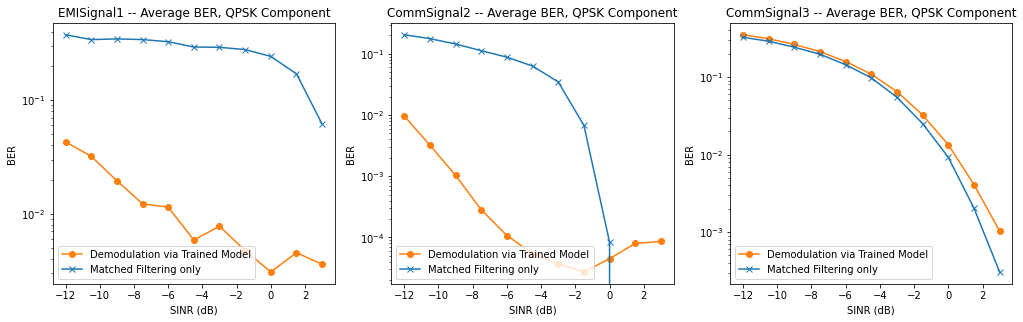

In [18]:
plt.figure(figsize=(17.2, 4.8)) 

val_or_test = 'val'
all_ref_str = ['EMISignal1', 'CommSignal2', 'CommSignal3']

for i in range(len(all_ref_str)):
    all_ber, all_default_ber, all_sinr = pickle.load(open(os.path.join('example','demod_bitregression','output',f'bitregression_{all_ref_str[i]}_{val_or_test}_demod.pickle'), 'rb'))
    mean_ber_per_sinr = np.array(all_ber).reshape(-1,100).mean(axis=1)
    mean_default_ber_per_sinr = np.array(all_default_ber).reshape(-1,100).mean(axis=1)
    sinr_axis = np.array(all_sinr).reshape(-1,100).mean(axis=1)

    plt.subplot(1, 3, i+1)
    plt.semilogy(sinr_axis, mean_ber_per_sinr, 'o-', color='tab:orange')
    plt.semilogy(sinr_axis, mean_default_ber_per_sinr, 'x-', color='tab:blue')
    plt.title(f'{all_ref_str[i]} -- Average BER, QPSK Component')
    plt.xlabel('SINR (dB)')
    plt.ylabel('BER') 
    plt.legend(['Demodulation via Trained Model', 'Matched Filtering only'], loc="lower left")

#### Reference Method 3: Supervised Learning-Based Separation to Estimate QPSK Waveform + Matched Filtering

(To be updated)

Similar to reference method 2, another machine learning approach is to train a "separation function" in a supervised learning fashion. Specifically, we can create labelled dataset where the inputs are examples of the mixture signals $y$ (for a particular interference class), and the outputs are the values of one of the components, for example the QPSK waveform $s$. This would hence be a supervised regression task, where the output is providing an estimate on a "cleaned-up" waveforn of the QPSK signal component, removing the effects of interference present. 

With a higher quality estimate of the QPSK signal through this separation block, we can then do a standard matched filtering to demodulate the signal. 

\[Plots to be added\]